# Advanced AI for Business Applications 
## Sequence to Sequence Model

#### Resources and references from MSBA 6461, Spring 2024, Mochen Yang   
Professor's GitHub link: https://github.com/mochenyang/MSBA6460-Advanced-AI.git

# Table of Contents
1. [Setup](#setup)
1. [Seq2Seq Model and the Encoder-Decoder Architecture](#encode_decode)
    - [Sequence-to-Sequence (Seq2Seq) Modeling](#encode_decode_s2s)
    - [Basic Ideas of the Encoder-Decoder Architecture](#encode_decode_architecture)
    - [Technical Details of the Encoder-Decoder Architecture](#encode_decode_tech)
    - [Implement Encoder-Decoder Architecture in Keras](#encode_decode_implement)
1. [Additional Resources](#resource)

# Setup <a name="setup"></a>

We will try out different models and architectures that you will learn in this notebook on a machine translation task, using the [Tab-delimited Bilingual Sentence Pairs](http://www.manythings.org/anki/) dataset. This dataset contains multiple pairs of corresponding sentences in two different languages. For all the demos below, I will specifically take the English-Spanish dataset (you can download it from Canvas). You are encouraged to try out other language pairs (though some languages may require special preprocessing steps). A lot of the code in this notebook is adapted from Tensorflow tutorial [Neural machine translation with attention](https://www.tensorflow.org/tutorials/text/nmt_with_attention).

Before building any models, we need to complete a few pre-processing steps, including:
1. Read in the dataset, parse each line, and store the corresponding sentences in English and Spanish into two numpy arrays;
2. For each sentence, tokenize it and represent it as a sequence of integer indices (just like what we did in the text classification case).

In [1]:
# Import necessary packages
import numpy as np
import tensorflow as tf
from tensorflow import keras
import re

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# Read in the dataset - note that we need to specify encoding="utf-8" when the language contains non ascii words.
sentences_english = []
sentences_spanish = []
for line in open('datasets/spa.txt', 'r', encoding = 'utf-8'):
    s_english, s_spanish, other = line.rstrip('\n').split('\t')
    
    # Before we store the English sentence, we need to do a few processing.
    # 1. We don't want to just discard punctuations. To make sure tokenization works properly, let's add a space between each punctuation and the preceding word. E.g., "Hi." -> "Hi ." This is done with regular expression (don't worry about it if you are not familiar with it).
    # 2. For reasons that will become clear later, we need to add two special "words" to indicate the beginning and end of each sentence.
    s_english = re.sub(r"([?.!,])", r" \1 ", s_english)
    s_english = re.sub(r'[" "]+', " ", s_english)
    s_english = s_english.strip()
    s_english = '<start> ' + s_english + ' <end>'
    sentences_english.append(s_english)
    
    # Similarly, do the two steps for Spanish sentences.
    s_spanish = re.sub(r"([?.!,¡¿])", r" \1 ", s_spanish)
    s_spanish = re.sub(r'[" "]+', " ", s_spanish)
    s_spanish = s_spanish.strip()
    s_spanish = '<start> ' + s_spanish + ' <end>' 
    sentences_spanish.append(s_spanish)   

sentences_english = np.array(sentences_english)
sentences_spanish = np.array(sentences_spanish)
# print to check
print(sentences_english)
print()
print(sentences_spanish)
print()
print('In total: ' + str(len(sentences_spanish)) + ' pairs of sentences.')

# The original data is quite large, and may result in high memory usage and long training time. Let's take a sample of 15000
idx = np.random.choice(list(range(len(sentences_spanish))), size = 15000, replace = False)
sentences_english = sentences_english[idx]
sentences_spanish = sentences_spanish[idx]

['<start> Go . <end>' '<start> Go . <end>' '<start> Go . <end>' ...
 '<start> A carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities . Some people try to reduce their carbon footprint because they are concerned about climate change . <end>'
 '<start> Since there are usually multiple websites on any given topic , I usually just click the back button when I arrive on any webpage that has pop-up advertising . I just go to the next page found by Google and hope for something less irritating . <end>'
 '<start> If you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>']

['<start> Ve . <end>' '<start> Vete . <end>' '<start> Vaya . <end>' ...
 '<start> Una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como 

In [12]:
# Text preprocessing - just like what we did for text classification
# we need one vectorization layer for each language

# For English, we want to lowercase, but don't want to strip punctuations.
def lowercase_only(text):
    return tf.strings.lower(text)

vectorize_layer_english = keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = None,
    standardize = lowercase_only,
    split = 'whitespace',
    ngrams = None,
    output_mode = 'int',
    output_sequence_length = None
)

vectorize_layer_spanish = keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = None,
    standardize = lowercase_only,
    split = 'whitespace',
    ngrams = None,
    output_mode = 'int',
    output_sequence_length = None
)

In [13]:
# Apply to English and check vocabulary
vectorize_layer_english.adapt(sentences_english)
english_vocabulary = vectorize_layer_english.get_vocabulary()
print(english_vocabulary)
print(len(english_vocabulary))

# also create a variable max_english to store max length of English sentences (will come in handy later)
max_english = vectorize_layer_english(sentences_english).shape[1]
print(max_english)

['', '[UNK]', '<start>', '<end>', '.', 'the', 'i', 'to', 'you', 'tom', 'a', '?', 'is', 'he', 'in', 'that', 'of', 'it', ',', 'was', 'do', 'have', 'my', 'me', 'this', 'for', 'she', "don't", 'are', 'what', 'his', 'on', 'we', 'mary', 'with', 'your', 'be', 'want', "i'm", 'not', 'and', 'like', 'at', 'know', 'him', 'can', 'go', 'her', 'has', 'as', 'there', 'time', 'did', 'will', 'had', 'very', 'how', "it's", 'all', 'they', 'about', 'think', "didn't", 'here', 'up', 'get', 'going', 'out', "can't", 'one', 'an', 'were', 'from', 'no', 'if', 'why', 'when', 'by', "doesn't", "you're", 'good', 'just', 'please', 'would', 'who', 'come', 'see', 'so', 'need', "i'll", 'been', "i've", 'more', 'help', 'could', 'work', 'take', 'than', 'tell', 'where', 'now', 'us', 'but', 'something', 'too', 'day', 'never', 'got', 'last', 'some', 'car', 'lot', '!', 'should', 'much', 'money', 'people', 'am', 'back', "isn't", 'home', 'our', 'said', 'told', 'say', 'off', 'really', 'went', 'only', 'thought', 'new', 'eat', 'any', '

In [14]:
# Apply to Spanish and check vocabulary
vectorize_layer_spanish.adapt(sentences_spanish)
spanish_vocabulary = vectorize_layer_spanish.get_vocabulary()
print(spanish_vocabulary)
print(len(spanish_vocabulary))

# also create a variable max_spanish to store max length of Spanish sentences (will come in handy later)
max_spanish = vectorize_layer_english(sentences_spanish).shape[1]
print(max_spanish)

['', '[UNK]', '<start>', '<end>', '.', 'de', 'que', 'no', 'a', 'tom', 'la', '?', '¿', 'el', 'en', 'es', 'un', 'me', ',', 'se', 'por', 'lo', 'una', 'los', 'qué', 'mi', 'Él', 'con', 'su', 'está', 'te', 'ella', 'le', 'para', 'mary', 'y', 'más', 'las', 'al', 'yo', 'muy', 'eso', 'del', 'tu', 'este', 'esta', 'tiene', 'estoy', 'tengo', 'quiero', 'estaba', 'fue', 'como', 'él', 'si', 'aquí', 'hacer', 'tiempo', 'puedo', 'todo', 'ha', 'casa', 'todos', 'hay', 'esto', 'algo', 'tan', 'mucho', 'puede', 'nada', 'favor', 'son', 'bien', 'ir', 'he', '!', '¡', 'gusta', 'vez', 'nos', 'trabajo', 'era', 'creo', 'quién', 'ser', 'ellos', 'solo', 'dijo', 'cuando', 'sé', 'ya', 'dos', 'estás', 'sus', 'cómo', 'nunca', 'mañana', 'ahora', 'dónde', 'verdad', 'están', 'pero', 'puedes', 'hablar', 'ese', 'dinero', 'tienes', 'hoy', 'había', 'tomás', 'hace', 'soy', 'tú', 'va', 'ver', 'quiere', 'nadie', 'mejor', 'día', 'poco', 'has', 'parece', 'noche', 'sabe', 'siempre', 'voy', 'libro', 'tenía', 'francés', 'quieres', 'ante

# Seq2Seq Model and Encoder-Decoder Architecture <a name="encode_decode"></a>

## Sequence-to-Sequence (Seq2Seq) Modeling <a name="encode_decode_s2s"></a>

The goal is a seq2seq model is to take a sequence (e.g., of texts) as input and predict another sequence (e.g., of texts). The input sequence and the output sequence _may not have the same length_. It is relevant for a lot of NLP tasks including:
- Machine Translation (turn a piece of text in language A into a piece of text in language B);
- Q&A (take a question and produce an answer);
- Speech recognition (predict text based on speech/sound);
- Conversational AI (e.g., chatbots).

<font color="blue"> The **encoder-decoder architecture** is one of the canonical neural network architecture for seq2seq modeling tasks. </font>

## Basic Ideas of the Encoder-Decoder Architecture <a name="encode_decode_architecture"></a>

The encoder-decoder architecture has three components: the **encoder**, the **context**, and the **decoder**. Among them, the encoder and the decoder are typically RNNs and the context is typically a vector. The three componenets have different roles:
- The encoder "reads" the input sequence, then produce a vector output at the end. That vector output is the context. In other words, the encoder "encodes" information in the input sequence into a numeric vector;
- The **context vector** can be thought of as a "summary" or "representation" of the information in the input sequence;
- The decoder takes the context vector, then "decodes" its information to produce the output sequence.

Take machine translation as an example, this architecture conceptually mimic how humans translate: read a sentence in language A (encoder), understand / digest it (context), then produce the translated sentence in language B (decoder).

<font color="red">Question: why do we need the context vector? Why can't we just directly predict the output sequence, one word at a time, as the encoder reads through the input sequence?</font> (recall the many-to-many RNN architecture that you learned in Yicheng's class). **Hint:** think about the lengths of input and output sequences.

Based on the roles of encoder and decoder, we can easily map out the RNN structures that we need:
- For the encoder, we need an RNN that takes a sequence input and produce a vector output at the end (i.e., many-to-one structure). This is exactly the same structure that we have used for classification purpose, _except that we don't need to get a final categorical prediction - we just need the hidden state of the RNN at the final time step_. <font color="red">Question: why use the hidden states?</font>;
- For the decoder, we need an RNN that takes a single vector as input and produce a sequence as output (i.e., one-to-many structure). More details below.

## Technical Details of the Encoder-Decoder Architecture <a name="encode_decode_tech"></a>

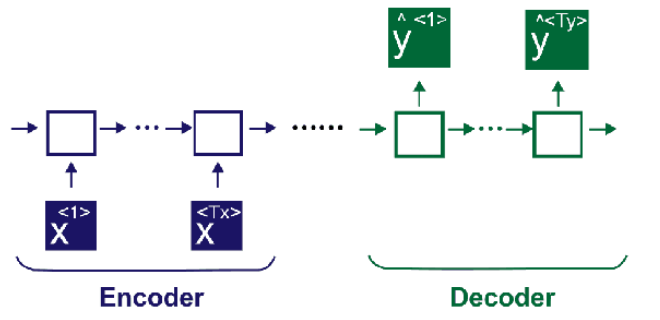

image credit: https://medium.com/analytics-vidhya/machine-translation-using-neural-networks-61ea85b39ad4

Consider a training dataset with $N$ **pairs** of input sequences and output sequences (e.g., in the case of machine translation, these may be $N$ pairs of corresponding sentences in two languages). Let's represent a particular input sequence as $\boldsymbol{X_n} = (x_1, \ldots, x_T)$ and the corresponding output sequence as $\boldsymbol{Y_n} = (y_1, \ldots, y_{T'})$. Importantly, $T$ may not equal $T'$, i.e., the two sequences may have different lengths.

**The encoder RNN**: The encoder RNN behaves just like a regular RNN that you have seen in the case of text classification. Its hidden state changes as it reads through the input sequence:
$$h_t^{(encoder)} = f(h_{t-1}^{(encoder)}, x_t)$$
where function $f()$ represent the activation function, and can be as simple as the hyperbolic tagent (i.e., simple RNN), or the complex LSTM.  

**The context vector**: The context vector $\boldsymbol{C}$, which serves as a "summary" of the entire input sequence, is simply the last hidden state of encoder RNN. In other words,
$$\boldsymbol{C} = h_T^{(encoder)}$$
<font color="red">The final state of h, i.e. h_T, is the "understanding of the whole sentence/content"</font>

**The decoder RNN**: The decoder RNN takes the context vector and predict the output sequence. In particular, it works as follows:  
<font color="red">Note that we initial the g_0 as h_T at the decoding process. </font>  
1. **<font color="blue">Set $h_0^{(decoder)} = \boldsymbol{C}$ (the context vector becomes the initial hidden state of decoder). Set $y_0$ as an empty string or a special character that indicates the beginning of a sequence.</font>**
2. Compute next hidden state as $h_t^{(decoder)} = f(h_{t-1}^{(decoder)},y_{t-1})$. Again, $f()$ is the activation function of your choice. (BTW, using $y_{t-1}$ as part of the input to compute the next hidden state in decoder RNN is called "teacher forcing");
3. Predict $\hat{y_t} = softmax(h_t^{(decoder)})$ as the next word in sequence;
4. Repeat steps 2-3, until some max length of the output sequence or a special character indicating the end of a sequence is reached.

During training, the loss function is constructed by comparing $(\hat{y_1}, \ldots, \hat{y_{T'}})$ with the ground truth $(y_1, \ldots, y_{T'})$, via categorical cross-entropy.

<font color="blue">During out-of-sample prediction, in step 2 of decoder, because y_{t-1} is unobserved, you can simply replace it with $\hat{y_{t-1}}$.</font> This way of putting the model's output back into the model to generate the next output is called _auto-regressive_ (related to, but not to be confused with, the auto-regressive model in time-series forecasting).

### New information input to the decoder at each time T

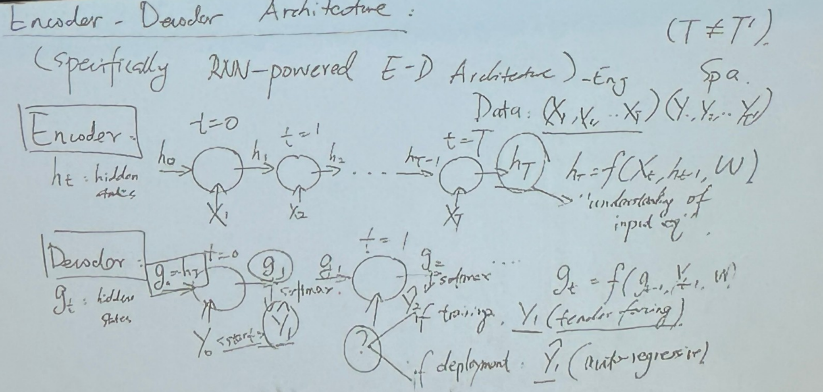

- Initial the decoder by h_T, the final state of the encoder  
- Y_0: the special token indicating the beginning of the embedded sentence  
- Y_1 ~ Y_t-1: 
    - If trainign, use the ground truth y_1 since we want to give the decoder "student" much more granular feedback, it's **teacher forcing**  
    - If deployed, use Y_1_hat, then it's a **self-regression**  
- Y_t: the special token indicating the end of the embedded sentence
- The lehgth of the softmax layer is the volabulari size of the target lenguage.  

If want the model can do other tasks then only translation, one needs to train the model on a diverse set of tasks.   
0 shot learning: give a new tasks haven't be trained before and give an example >> it can learn and perform the task. 

If the article you want to translate is too long, we may face the challenge that the context vector has no enough capacity to capture all the information. 

## Implement Encoder-Decoder Architecture in Keras <a name="encode_decode_implement"></a>

<font color="red">Disclaimer: </font>Different from what we did for text classification (i.e., mostly calling existing functions), we need to do quite a bit of implementations by ourselves here. As such, there are multiple ways to implement the same thing, and my code below should be treated as _a demonstration_, rather than the most efficient / general-purpose way of implementing the encoder-decoder architecture.

As demonstration, I use GRU cells for both the encoder RNN and the decoder RNN.   
Of course, one can use LSTM cells as well. See [Character-level recurrent sequence-to-sequence model](https://keras.io/examples/nlp/lstm_seq2seq/) as an example.

### Prepare for encoder and decoder

In [17]:
# Assemble the Encoder RNN
# It consists of an input layer, an embedding layer, and a GRU layer
# For demonstration, I will set the embedding dimensions and number of GRU units to be 64 (note: the two do not necessarily need to have the same dimension in general)

encoder_inputs = keras.layers.Input(shape = (None,), # shape = (None,) indicates that the length of each input is not known in advance
                                    name = "encoder_input") 
x = keras.layers.Embedding(input_dim = len(vectorize_layer_english.get_vocabulary()),
                           output_dim = 64,
                           mask_zero = True,
                           name = "encoder_embedding")(encoder_inputs)
encoder_h_all, encoder_h_final = keras.layers.GRU(units = 64,
                                                   return_state = True,  # Set return_state = True to get the hidden state at the end, i.e., the context vector
                                                   name = "encoder_gru")(x)

In [18]:
# Assemble the Decoder RNN
# It also consists of an input layer, an embedding layer, and a GRU layer

decoder_inputs = keras.layers.Input(shape = (None,), name = "decoder_input")
x = keras.layers.Embedding(input_dim = len(vectorize_layer_spanish.get_vocabulary()),
                           output_dim = 64,
                           mask_zero = True,
                           name = "decoder_embedding")(decoder_inputs)
decoder_h_all, decoder_h_final = keras.layers.GRU(units = 64,
                                                  return_sequences = True,  # MUST return_sequences = True to allow the RNN to output its hidden state at each step (rathar than only at the end)
                                                  return_state = True,
                                                  name = "decoder_gru")(x, initial_state = encoder_h_final)  # Setting initial_state = encoder_states passes the context vector to decoder RNN
# Then turn decoder RNN hidden state at each step into a prediction
decoder_predictions = keras.layers.Dense(units = len(vectorize_layer_spanish.get_vocabulary()),
                                         activation='softmax',
                                         name = "decoder_dense")(decoder_h_all)

<font color="blue">Coding Note: what's the difference between return_state and return_sequences here?</font>

When specifying RNN cells/layers in Keras, return_state controls whether you want the layer to return the hidden state at the _final step_, and return_sequences controls whether you want the hidden state at _every step_. Take GRU as an example:
- `output = GRU(units, return_state = False, return_sequences = False)` means you only want the final hidden state stored in output;
- `output, state = GRU(units, return_state = True, return_sequences = False)` also means you only want the final hidden state. Here, output and state will be two tensors of the same values;
- `output, state = GRU(units, return_state = True, return_sequences = True)` means you want both the final state and state at every step. Here, output will contain hidden state of every step (i.e., it will be a tensor with a "time" dimension), whereas state will only store the final hidden state.

In [19]:
# Put encoder and decoder RNNs into a keras Model object, so it can be trained
# Documentation here: https://www.tensorflow.org/api_docs/python/tf/keras/Model
model = keras.Model(inputs = [encoder_inputs, decoder_inputs],
                    outputs = decoder_predictions)

In [23]:
# We still need to do two things to prepare the actual data for decoder_outputs:
# 1. We need to move it "one step ahead" of the actual output Spanish sentences, becauses of the teacher forcing training strategy: we use encoder states + decoder input at t to predict decoder input at t+1
# 2. Because "decoder_outputs" are generated by a dense layer via softmax activation, we need to one-hot encode the Spanish sentences
temp = vectorize_layer_spanish(sentences_spanish)

# the decoder_output_data tensor should have shape (num_sentences, max_sentence_length, size_of_vocabulary)
decoder_predictions_oneahead = np.zeros((temp.shape[0], temp.shape[1], len(vectorize_layer_spanish.get_vocabulary())), dtype = "float32")
for i in range(temp.shape[0]):
    for j in range(1, temp.shape[1]): # start from 1, because we want to move "one step ahead"
        decoder_predictions_oneahead[i, j-1, temp[i,j]] = 1

### Train the model

In [112]:
# Train the model
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Note: the following training will run for about 1 hour on a regular laptop
model.fit([vectorize_layer_english(sentences_english), vectorize_layer_spanish(sentences_spanish)],
          decoder_predictions_oneahead,
          batch_size = 32,
          epochs = 10,
          validation_split = 0.2)

Epoch 1/10
375/375 [==============================] - 349s 931ms/step - loss: 0.9143 - accuracy: 0.2374 - val_loss: 0.7800 - val_accuracy: 0.3433
Epoch 2/10
375/375 [==============================] - 340s 905ms/step - loss: 0.7620 - accuracy: 0.3626 - val_loss: 0.7345 - val_accuracy: 0.3778
Epoch 3/10
375/375 [==============================] - 325s 868ms/step - loss: 0.7247 - accuracy: 0.3856 - val_loss: 0.7104 - val_accuracy: 0.3979
Epoch 4/10
375/375 [==============================] - 316s 842ms/step - loss: 0.6987 - accuracy: 0.4034 - val_loss: 0.6915 - val_accuracy: 0.4138
Epoch 5/10
375/375 [==============================] - 328s 874ms/step - loss: 0.6791 - accuracy: 0.4175 - val_loss: 0.6795 - val_accuracy: 0.4233
Epoch 6/10
375/375 [==============================] - 338s 902ms/step - loss: 0.6648 - accuracy: 0.4279 - val_loss: 0.6747 - val_accuracy: 0.4255
Epoch 7/10
375/375 [==============================] - 334s 891ms/step - loss: 0.6527 - accuracy: 0.4367 - val_loss: 0.6658 -

### Inference 

We are not done yet! Using a trained encoder-decoder model to make predictions is more complicated than simply `model.predict()`. We need to build a prediction function that takes a given english sentence, process it, run through the network, and generate Spanish predictions one word at a time. This is called **inference**.

First, we need to construct the encoder and decoder for deployment. This step looks very similar to what we did when we construct them for training, but now we use the trained model object.

In [34]:
# Take a look at all the trained layers in the model object - we will use them to construct encoder/decoder for deployment
model.layers
# if you forgot what each layer represents, you can retrieve its name to remind yourself. For example
#print(model.layers[5].name)

In [ ]:
# The order of the layers: 

# encoder input layer
# decoder input layer
# encoder embedding layer
# decoder embedding layer
# encoder gru layer
# decoder gru layer
# output layer

In [114]:
# Construct encoder
encoder_inputs = model.input[0]
encoder_embedding_layer = model.layers[2]
encoder_embedded_inputs = encoder_embedding_layer(encoder_inputs)
encoder_gru = model.layers[4]
encoder_h_all, encoder_h_final = encoder_gru(encoder_embedded_inputs)
encoder_model = keras.Model(inputs = encoder_inputs,
                            outputs = encoder_h_final)

In [115]:
# Example: use the constructed encoder to encode a sentence. The output will be a 64-dimensional context vector
# See the "encoder hidden state" with your own eyes!
encoder_model.predict(vectorize_layer_english(['Hi']))

array([[ 0.06379634, -0.06867911,  0.0224181 , -0.01005947,  0.01135689,
         0.02713817,  0.06173227,  0.0315777 ,  0.0854506 ,  0.04984908,
         0.03262766, -0.06452022,  0.02338152,  0.00326141,  0.00352042,
         0.04879302, -0.00934004,  0.02815293, -0.04780437, -0.0181174 ,
         0.02910002, -0.06143535, -0.068152  , -0.04027976,  0.02581373,
         0.00888741, -0.01559817,  0.07280658,  0.14587033, -0.06181121,
        -0.07616357, -0.00798858, -0.07944083,  0.056419  , -0.01836442,
         0.05653227,  0.03495847,  0.06762259,  0.00858808, -0.01498305,
        -0.06635191,  0.11128965,  0.1195935 ,  0.06607796, -0.02631752,
        -0.1413462 , -0.04873307,  0.08222912, -0.00267215,  0.08329066,
         0.01642701, -0.05979476, -0.09580483,  0.00491492, -0.03502396,
         0.06356701, -0.01445538, -0.05308008,  0.11230695, -0.1122926 ,
        -0.00118725,  0.04316691, -0.08154774, -0.00367362]],
      dtype=float32)

In [116]:
# Construct decoder
decoder_inputs = model.input[1]
decoder_embedding_layer = model.layers[3]
decoder_embedded_inputs = decoder_embedding_layer(decoder_inputs)
decoder_gru = model.layers[5]
decoder_states_inputs = keras.layers.Input(shape = (64,)) # during actual deployment, this will be the encoder final hidden states
decoder_h_all, decoder_h_final = decoder_gru(decoder_embedded_inputs,
                                             initial_state = decoder_states_inputs) 
decoder_dense = model.layers[6]
decoder_predictions = decoder_dense(decoder_h_all)
# technical note: when the inputs / outputs of the keras.Model() has multiple parts, it must be a list of objects
decoder_model = keras.Model(inputs = [decoder_inputs, decoder_states_inputs],
                            outputs = [decoder_predictions, decoder_h_all])

In [117]:
# Now, let's build the inference function
def translate(input_sentence):
    # first, run it through the encoder model to get context vector
    states_value = encoder_model.predict(vectorize_layer_english(input_sentence))
    
    # next, let's construct a target_sentence and a predict_sentence
    # the target start with the "<start>" word, and serves as the input to decoder during teacher forcing - it is the y_{t-1} element when t = 1
    # the predict_sentence is our ultimate prediction
    target = '<start>'
    predict_sentence = ''
    predict_sentence_len = 0
    stop = False
    while not stop:
        output_softmax_probs, h = decoder_model.predict([vectorize_layer_spanish(target), states_value])
        # get the output word based on "output_softmax_probs" (which is the softmax output probabilities)
        # the weired index [0,-1,:] here is because the output shape is (batch_size, num_sentences, num_words)
        output_word_idx = np.argmax(output_softmax_probs[0,-1,:])
        output_word = spanish_vocabulary[output_word_idx]
        predict_sentence += output_word + ' '
        predict_sentence_len += 1
        
        # check stop conditions
        if output_word == '<end>' or predict_sentence_len > max_spanish:
            stop = True
            
        # update the target to be the current output, for next prediction
        target = output_word
        
        # also update the hidden state of decoder RNN, for next prediction
        states_value = h
    
    return predict_sentence

In [121]:
translate(['<start> Was it you that left the door open last night ? <end>'])

'¿ puedo ir a la casa de la casa ? <end> '

# Additional Resources <a name="resource"></a>

- Encoder-Decoder Architecture:
    - [Understanding Encoder-Decoder Sequence to Sequence Model](https://towardsdatascience.com/understanding-encoder-decoder-sequence-to-sequence-model-679e04af4346). This is an accessible introduction to seq2seq modeling. I recommend reading it;
    - [Character-level recurrent sequence-to-sequence model](https://keras.io/examples/nlp/lstm_seq2seq/);
    - Original research papers that proposed the encoder-decoder architecture: [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215); [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078)